# <font style="color:blue">RetinaNet using Detectron2</font>

In this notebook, we will fine-tune the RetinaNet model using Detectron2.

**In the notebook, we will go through the followings:**

- Introduction to Detectron2,


- Installation of Detectron2,


- Fine-tuning of RetinaNet using Detectron2, and


- Introduction to COCO Detection Evaluation and Model Evaluation: The COCO evaluation metric is a standard metric for object detection evaluation. 

# <font style="color:blue">1. Introduction to Detectron2</font>

Detectron is an open source object detection platform provided by FACEBOOK AI Research. The goal of Detectron is to provide a high-quality, high-performance codebase for object detection research. It is designed to be flexible in order to support rapid implementation and evaluation of novel research. Including the advancements of the project, Detectron2 is a groundup rewrite of Detectron and written in Pytorch. 

It includes high quality implementations of state of the art object detection algorithms, including Densepose, Panoptic feature pyramid networks and many variants of the Mask RCNN. DensePose (dense human pose) estimation aims at mapping all human pixels of an RGB image to the 3D surface of the human body. Panoptic segmentation combines instance segmentation which is used to recognize distinct foreground objects such as animals or people with the semantic segmentation which labels pixels in the image background with classes, such as road, sky, or grass.

It has a modular design that allows users to plug custom module implementations into almost any part of an object detection system. This means that many new research projects can be written in hundreds of lines of code with a clean separation between the core Detectron2 library and the novel research implementation. Facebook AI Research is using Detectron2 to design and train the next-generation pose detection models that power Smart Camera, the AI camera system in Facebook’s Portal video-calling devices.
   
Now, lets get started with Detectron2.

# <font style="color:blue">2. Installation</font>

Install Detectron2 from the pre-built Detrectron2. The pre-build Detectron can be used only with the latest version of PyTorch.


We are assuming that we have the latest version of `PyTorch` and `OpenCV` installed.  Let's install `pycocotools` and pre-built `detectron2`. 


##  <font style="color:green">2.1. Install pycocotools</font> 
   - COCO is a large image dataset designed for object detection, segmentation, person keypoints detection, stuff segmentation, and caption generation. This package Python APIs that assists in loading, parsing, and visualizing the annotations in COCO.


In [1]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

##  <font style="color:green">2.2. Install Pre-built Detectron2</font> 

In [2]:
# for CUDA 10.1:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

You can replace `cu101` with `cu{100,92}` or `cpu`.

**For any errors during the installation, refer to this <a href="https://detectron2.readthedocs.io/tutorials/install.html#common-installation-issues">link</a> from the official installation guide.**

# <font style="color:blue">3. Fine-tuning of RetinaNet </font>

We are already familiar with the concept of RetinaNet. Detectron2 has a pre-trained RetinaNet model. Here, we will load the pre-trained RetinaNet model and fine-tune to build a traffic-sign detector.

##  <font style="color:green">3.1. Download the Dataset</font> 

**[Download the traffic-sign dataset](https://www.dropbox.com/s/d8y6uc06027fpqo/traffic_sign_data.zip?dl=1)**

Download the traffic-sign dataset from [here](https://www.dropbox.com/s/d8y6uc06027fpqo/traffic_sign_data.zip?dl=1) and unzip it. Place the unzipped directory to the notebook directory. 

We will have the following directory structure:

```
traffic_sign_data/
├── JPEGImages
├── labels
├── traffic_sign_test.txt
└── traffic_sign_train.txt
```

- **`JPEGImages`:** It is a directory that has all images in `.jpg` format.


- **`labels`:** It is a directory that has `.txt` files with bounding boxes corresponds to each `.jpg` images.


- **`traffic_sign_train.txt`:** Images are divided into `training` and `test` data. This file has paths of all training images.


- **`traffic_sign_test.txt`:** This file has paths of all validation images.

**It has `1211` training and `305` validation dataset.**

In [3]:
%matplotlib inline

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training object detector
from detectron2.engine import DefaultTrainer
# DefaultPredictor is class for inference
from detectron2.engine import DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg
# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# BoxMode support bounding boxes in different format
from detectron2.structures import BoxMode

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

##  <font style="color:green">3.2. Dataset in Detectron2 Format</font> 

Detectron2 needs data in a list of dictionary (`list[dict]`) format.

The dictionary (`dict`) should have the following format, :
```
{
    'file_name': str,              # path of the image
    'image_id': int or str,        # a unique id that identifies the image.
    'height': int,                 # height of the image,
    'width': int,                  # width of the image
    'annotations': [
            {
                'bbox': [xmin, ymin, xmax, ymax],   # bounding box in XYXY_ABS format
                'bbox_mode': BoxMode.XYXY_ABS,      # it supports bounding box in different format
                'category_id': int,                 # class id 
                'iscrowd': 0 or 1                   # if it is a crowd of the objects. 
                                                    # In our case it will be 0
            }
        ]
}
```

Get more details of the format [here](https://detectron2.readthedocs.io/tutorials/datasets.html)

Get details of `BoxMode` [here](https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode)

In [5]:
# write a function that loads the dataset into detectron2's standard format
def get_traffic_sign_dicts(data_root, txt_file):
    dataset_dicts = []
    filenames = []
    csv_path = os.path.join(data_root, txt_file)
    with open(csv_path, "r") as f:
        for line in f:
            filenames.append(line.rstrip())

    for idx, filename in enumerate(filenames):
        record = {}
        
        image_path = os.path.join(data_root, filename)
        
        height, width = cv2.imread(image_path).shape[:2]
        
        record['file_name'] = image_path
        record['image_id'] = idx
        record['height'] = height
        record['width'] = width
        
        image_filename = os.path.basename(filename)
        image_name = os.path.splitext(image_filename)[0]
        annotation_path = os.path.join(data_root, 'labels', '{}.txt'.format(image_name))
        annotation_rows = []

        with open(annotation_path, "r") as f:
            for line in f:
                temp = line.rstrip().split(" ")
                annotation_rows.append(temp)

        objs = []
        for row in annotation_rows:
            xcentre = int(float(row[1])*width)
            ycentre = int(float(row[2])*height)
            bwidth = int(float(row[3])*width)
            bheight = int(float(row[4])*height)
            
            xmin = int(xcentre - bwidth/2)
            ymin = int(ycentre - bheight/2)
            xmax = xmin  + bwidth
            ymax = ymin + bheight
    
            obj= {
                'bbox': [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                # alternatively, we can use bbox_mode = BoxMode.XYWH_ABS
                # 'bbox': [xmin, ymin, bwidth, bheight],
                # 'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': int(row[0]),
                'iscrowd': 0
            }
        
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

##  <font style="color:green">3.3. Register Dataset</font> 

In detectron2, we have to register data and its metadata (e.g., classes) that will be used for training and validation.

Let's start our configuration.

In [6]:
# configurations

data_root = 'traffic_sign_data'
train_txt = 'traffic_sign_train.txt'
test_txt = 'traffic_sign_test.txt'

train_data_name = 'traffic_sign_train'
test_data_name = 'traffic_sign_test'

thing_classes = ['traffic-sign']

output_dir = 'outputs'

def count_lines(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

train_img_count = count_lines(os.path.join(data_root, train_txt))

#### `detectron2.data.DatasetCatalog.register`:
It is used to register data with detectron2.

**Parameters:**

- `name` (`str`): the name that identifies a dataset, e.g. “coco_2014_train”.


- `func` (`callable`): a callable which takes no arguments and returns a list of dicts (`list[dict]`).

Get details of `DatasetCatalog` [here](https://detectron2.readthedocs.io/modules/data.html#detectron2.data.DatasetCatalog).

Our dataset function (`get_traffic_sign_dicts`) returns a list of dictonary (`list[dict]`) but requires arguments. By using the `lambda` function, we can create a function that will not take any argument as follows:

```
callable_fun = lambda: get_traffic_sign_dicts(data_root, train_txt)
```

#### `detectron2.data.MetadataCatalog`:

MetadataCatalog provides access to `Metadata` of a given dataset.

The metadata associated with a certain name is a singleton: once created, the metadata will stay alive and will be returned by future calls to `get(name)`.

#### `detectron2.data.MetadataCatalog.get`:

**Parameters:**	

- `name` (`str`): name of a dataset (e.g. traffic_sign_train).

**`Returns`:** `Metadata` The Metadata instance associated with this name, or create an empty one if none is available.

**We can update our classes using returned `metadata.set(thing_classes=thing_classes)`**

Get details of `MetadataCatalog` [here](https://detectron2.readthedocs.io/modules/data.html#detectron2.data.MetadataCatalog).

In [7]:
# Register train and test data
# dataset can be registered only once with one name

# register train data
DatasetCatalog.register(name=train_data_name, 
                        func=lambda: get_traffic_sign_dicts(data_root, train_txt))
train_metadata = MetadataCatalog.get(train_data_name).set(thing_classes=thing_classes)

# register test data
DatasetCatalog.register(name=test_data_name, 
                        func=lambda: get_traffic_sign_dicts(data_root, test_txt))
test_metadata = MetadataCatalog.get(test_data_name).set(thing_classes=thing_classes)

##  <font style="color:green">3.4. Visualize the Data</font> 

Detectron2 has a lot of different visualization functionality that is useful is object detection visualization.

Get details of different Visualizer function [here](https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.visualizer.Visualizer).

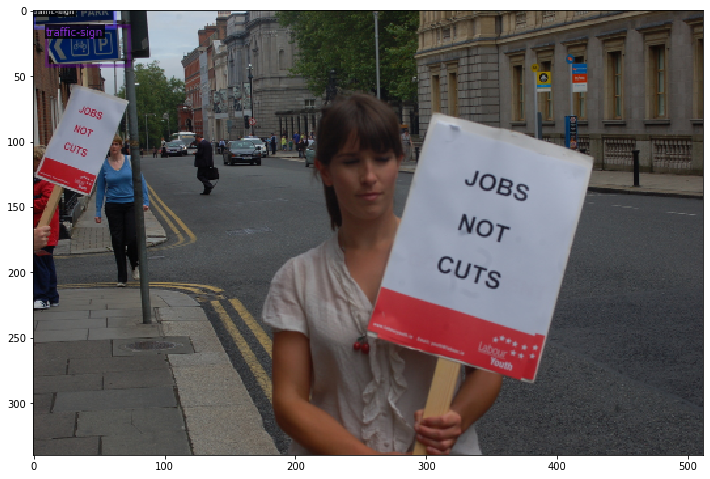

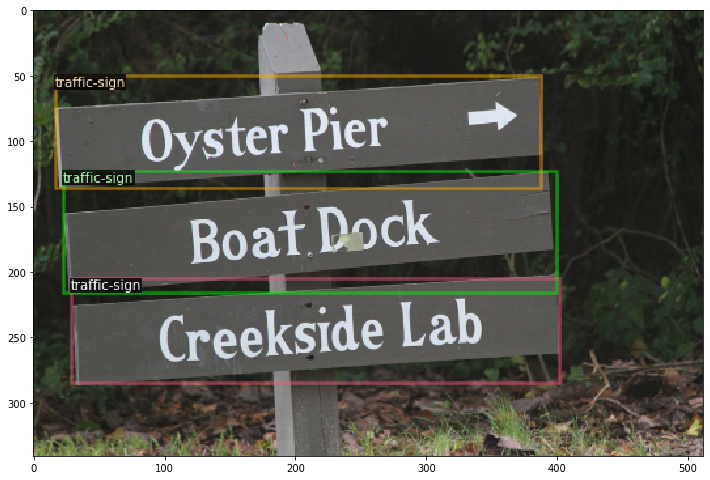

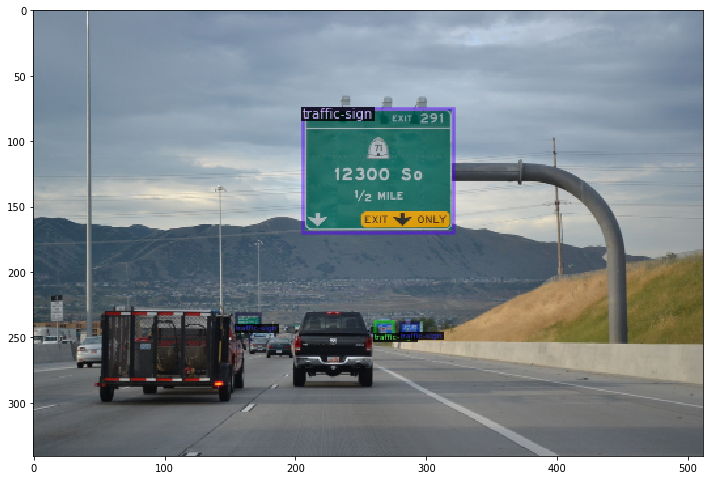

In [8]:
# lets visualize the data

test_data_dict = get_traffic_sign_dicts(data_root, test_txt)

for d in random.sample(test_data_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=test_metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

##  <font style="color:green">3.5. Detectron2 Configuration</font> 

Get default configuration of detectron2 and update parameters according to our requirements. 

Get more details of the configuration [here](https://detectron2.readthedocs.io/modules/config.html#).

In [9]:
# detectron2 configuration

# default confugration
cfg = get_cfg()

# update configuration with RetinaNet configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# We have registered the train and test data set with name traffic_sign_train and traffic_sign_test. 
# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()


Loading config /home/ubuntu/anaconda3/envs/pc_det/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [10]:
# data loader configuration
cfg.DATALOADER.NUM_WORKERS = 4

In [11]:
# Update model URL in detectron2 config file
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

In [12]:
# slover configuration

# batch size
cfg.SOLVER.IMS_PER_BATCH = 4

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.001

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
# lets convert number of epoch to number or iteration (max iteration)

epoch = 2
max_iter = int(epoch * train_img_count / cfg.SOLVER.IMS_PER_BATCH)
max_iter = 500

cfg.SOLVER.MAX_ITER = max_iter 

In [13]:
# number of output class
# we have only one class that is Traffic Sign
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)

In [14]:
# update create ouptput directory 
cfg.OUTPUT_DIR = output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

##  <font style="color:green">3.6. Training</font> 

Now, let's fine-tune a coco-pretrained `R50-FPN RetinaNet` model on the traffic-sign dataset.

#### `detectron2.engine.defaults.DefaultTrainer(cfg)`

A trainer with default training logic. Compared to SimpleTrainer, it contains the following logic in addition:

- Create model, optimizer, scheduler, dataloader from the given config.


- Load a checkpoint or `cfg.MODEL.WEIGHTS`, if exists, when `resume_or_load` is called.


- Register a few common hooks

Get more details [here](https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultTrainer).

##  <font style="color:purple">Set up TensorBoard</font> 

Before starting the training, let's set up the TensorBoard.


In [15]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir outputs

Reusing TensorBoard on port 6006 (pid 24681), started 3:22:04 ago. (Use '!kill 24681' to kill it.)

In [16]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

# if rseume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()

[04/01 08:33:29 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[04/01 08:33:44 d2.data.build]: Removed 0 images with no usable annotations. 1211 images left.
[04/01 08:33:44 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| traffic-sign | 2629         |
|              |              |
[04/01 08:33:44 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[04/01 08:33:44 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/01 08:33:44 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/01 08:33:44 d2.data.build]: Using training sampler TrainingSampler


'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[04/01 08:33:44 d2.engine.train_loop]: Starting training from iteration 0
[04/01 08:33:54 d2.utils.events]:  eta: 0:03:39  iter: 19  total_loss: 1.502  loss_cls: 1.260  loss_box_reg: 0.217  time: 0.4545  data_time: 0.0281  lr: 0.000020  max_mem: 3946M
[04/01 08:34:03 d2.utils.events]:  eta: 0:03:35  iter: 39  total_loss: 1.204  loss_cls: 1.011  loss_box_reg: 0.143  time: 0.4637  data_time: 0.0089  lr: 0.000040  max_mem: 3947M
[04/01 08:34:13 d2.utils.events]:  eta: 0:03:26  iter: 59  total_loss: 0.893  loss_cls: 0.820  loss_box_reg: 0.111  time: 0.4667  data_time: 0.0084  lr: 0.000060  max_mem: 3948M
[04/01 08:34:23 d2.utils.events]:  eta: 0:03:19  iter: 79  total_loss: 0.696  loss_cls: 0.612  loss_box_reg: 0.067  time: 0.4726  data_time: 0.0077  lr: 0.000080  max_mem: 3948M
[04/01 08:34:32 d2.utils.events]:  eta: 0:03:10  iter: 99  total_loss: 0.512  loss_cls: 0.423  loss_box_reg: 0.089  time: 0.4728  data_time: 0.0078  lr: 0.000100  max_mem: 3948M
[04/01 08:34:42 d2.utils.events]:  e

##  <font style="color:green">3.7. Inference</font> 

Now, let's run inference with the trained model on the traffic-sign validation dataset. First, let's create a predictor using the model we just trained.

#### `detectron2.engine.defaults.DefaultPredictor(cfg)`

Create a simple end-to-end predictor with the given config that runs on single device for a single input image.
Compared to using the model directly, this class does the following additions:

- Load checkpoint from cfg.MODEL.WEIGHTS.


- Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.


- Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.


- Take one input image and produce a single output, instead of a batch.

Get more details [here](https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultPredictor)

In [17]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# update RetinaNet score threshold 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

cfg.DATASETS.TEST = (test_data_name,)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)


traffic_sign_data/JPEGImages/2e158b0c58e4c644.jpg
{'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 33.0081,  85.4281, 795.4218, 566.1072]], device='cuda:0')), scores: tensor([0.5076], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


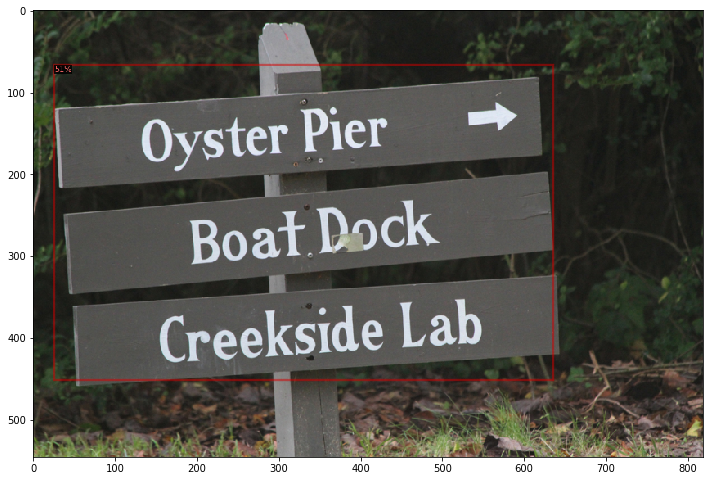

traffic_sign_data/JPEGImages/3077368c71930382.jpg
{'instances': Instances(num_instances=1, image_height=681, image_width=1024, fields=[pred_boxes: Boxes(tensor([[173.6660, 215.3089, 346.8427, 367.5176]], device='cuda:0')), scores: tensor([0.7410], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


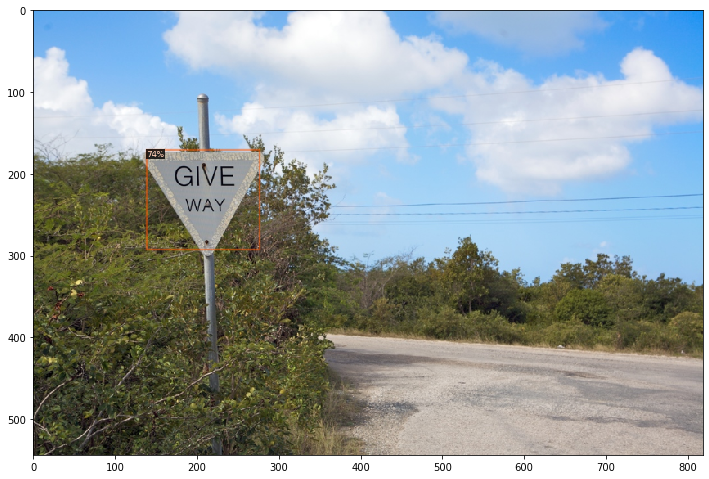

traffic_sign_data/JPEGImages/13a9a5a043831035.jpg
{'instances': Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 52.2757, 273.6524, 149.8762, 320.1179]], device='cuda:0')), scores: tensor([0.8692], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


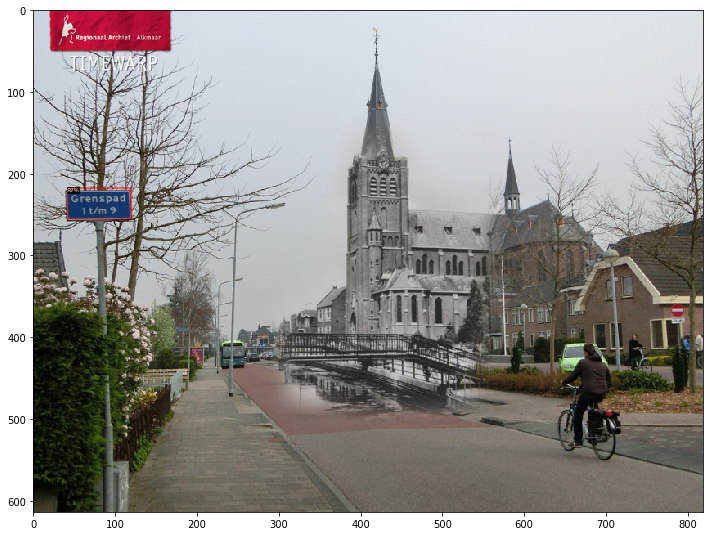

In [18]:
# let's have a look on prediction

for d in random.sample(test_data_dict, 3):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (12, 12))
    plt.imshow(v.get_image())
    plt.show()

# <font style="color:blue">4. Introduction to COCO Detection Evaluation and Model Evaluation</font>

We will evaluate the model performance using AP metric implemented in COCO API.

##  <font style="color:green">4.1. Introduction to COCO Detection Evaluation </font> 

- We are already familiar with the mean average precession (`mAP`). Coco evaluation metric `AP` is equivalent to `mAP`. 


- Instead of evaluating `mAP` (`AP`) for a single `IoU` (e.g., `IoU=0.5`), it evaluates on a different set of `IoUs`.


- It also has a concept of the `small`, `medium`, and `large` areas for which it evaluates `AP` (`mAP`). 


- It also measures recall of detection. For recall, it categorizes images into `3-classes`: (i) maximum `one` detection per image, (ii) maximum `ten` detections per image, and (iii) maximum `100` detections per class.

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

Get more details [here](http://cocodataset.org/#detection-eval).

##  <font style="color:green">4.2. Model Evaluation </font>

We will use the following detectron2 API to evaluate our model on the COCO evaluation metric.


#### `detectron2.evaluation.inference_on_dataset(model, data_loader, evaluator)`

Get details [here](https://detectron2.readthedocs.io/modules/evaluation.html#detectron2.evaluation.inference_on_dataset).

- Model


- Dataloader

  `build_detection_test_loader(cfg, dataset_name, mapper=None)`
  - mapper (`callable`) – a callable which takes a sample (`dict`) from dataset and returns the format to be consumed by the model. By default it will be DatasetMapper(`cfg`, `False`)
  - Get more details [here](https://detectron2.readthedocs.io/modules/data.html#detectron2.data.build_detection_test_loader).
  
  
- Evaluator

  `COCOEvaluator(dataset_name, cfg, distributed, output_dir=None)`
  - Evaluate object proposal, instance detection/segmentation, keypoint detection outputs using COCO’s metrics and APIs.
  - Get more details [here](https://detectron2.readthedocs.io/modules/evaluation.html#detectron2.evaluation.COCOEvaluator)



In [19]:

# create directory for evaluation
eval_dir = os.path.join(cfg.OUTPUT_DIR, 'coco_eval')
os.makedirs(eval_dir, exist_ok=True)

# create evaluator instance with coco evaluator
evaluator = COCOEvaluator(dataset_name=test_data_name, 
                          cfg=cfg, 
                          distributed=False, 
                          output_dir=eval_dir)

# create validation data loader
val_loader = build_detection_test_loader(cfg, test_data_name)

# start validation
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/01 08:37:50 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'traffic_sign_test'. Trying to convert it to COCO format ...
[04/01 08:37:50 d2.data.datasets.coco]: Cached annotations in COCO format already exist: outputs/coco_eval/traffic_sign_test_coco_format.json
[04/01 08:37:52 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| traffic-sign | 305          |
|              |              |
[04/01 08:37:52 d2.data.common]: Serializing 134 elements to byte tensors and concatenating them all ...
[04/01 08:37:52 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/01 08:37:52 d2.evaluation.evaluator]: Start inference on 134 images
[04/01 08:37:54 d2.evaluation.evaluator]: Inference done 11/134. 0.0635 s / img. ETA=0:00:07
[04/01 08:37:59 d2.evaluation.evaluator]: Inference done 98/134. 0.0571 s / img. ETA=0:00:02
[04/01 08:38:01 d2.evaluation.evaluator]: Total infere

OrderedDict([('bbox',
              {'AP': 46.929249128913604,
               'AP50': 64.84787109310197,
               'AP75': 52.192580558118216,
               'APs': 14.298624986712746,
               'APm': 37.397789813026826,
               'APl': 66.35990456070807})])

# <font style="color:blue">References</font>

- [Detectron2 Tutorials](https://detectron2.readthedocs.io/tutorials/index.html)


- [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf) (RetinaNet)


- [Detectron2 GitHub](https://github.com/facebookresearch/detectron2)


- [Official Colab Tutorial from Detectron2](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)


- [COCO dataset Detection Evaluation](http://cocodataset.org/#detection-eval)